In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# --- read data --- 

path = '/scratch/pchen25/clim680_dataset/MidMiocene/'
file_Pi = 'Mio_Pi/B.MMIOx2_C5_280_WISOon.cam.clim_1900_1999.nc'
file_Mio = 'Mio_Mio/B.MMIOx2_C5_280_WISOon_aeroZonal.cam.clim_100_300.nc'

ds_Pi = xr.open_mfdataset(path+file_Pi)
ds_Mio = xr.open_mfdataset(path+file_Mio)

ds_Pi

<xarray.Dataset>
Dimensions:    (time: 1200, lat: 96, lon: 144, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time       (time) object 1900-02-01 00:00:00 ... 2000-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables:
    PRECC      (time, lat, lon) float32 dask.array<chunksize=(1200, 96, 144), meta=np.ndarray>
    PRECL      (time, lat, lon) float32 dask.array<chunksize=(1200, 96, 144), meta=np.ndarray>
    TS         (time, lat, lon) float32 dask.array<chunksize=(1200, 96, 144), meta=np.ndarray>
    time_bnds  (time, nbnd) object dask.array<chunksize=(1200, 2), meta=np.ndarray>
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             B.MMIOx2_C5_280_WISOon
    title:            UNSET
    logname:          pacosta
    host:             r8i0n31
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /glade/scratch/pacosta/B.MMIOx2_C5_280_WISOon/run/B.MMI...
    topography_file:  /glade/work/pacosta/PaleoBC/heroldn/gx1vMIO/cami_bnd_to...
    history:          Thu Nov  2 18:37:20 2023: ncrcat ./B.MMIOx2_C5_280_WISO...
    NCO:              netCDF Operators version 5.1.4 (Homepage = http://nco.s...

## Nino3
Definition: (5S-5N; 90W-150W)

In [17]:
# --- (var.): TS ---

var = 'TS'
ts_Pi = ds_Pi[var]
ts_Mio = ds_Mio[var][1200:2400,:,:]

# --- Anomaly ---
ts_Pi_gb = ts_Pi.groupby('time.month')
ts_Mio_gb = ts_Mio.groupby('time.month')
ts_Pi_anom = ts_Pi_gb - ts_Pi_gb.mean(dim='time')
ts_Mio_anom = ts_Mio_gb - ts_Pi_gb.mean(dim='time')

ts_Nino3_Pi = ts_Pi_anom.sel(lat=slice(-5, 5), lon=slice(210, 270))
ts_Nino3_Mio = ts_Mio_anom.sel(lat=slice(-5, 5), lon=slice(210, 270))

weights = np.cos(np.deg2rad(ts_Nino3_Pi.lat))
Nino3_Pi = ts_Nino3_Pi.weighted(weights).mean(dim=['lon','lat'])
Nino3_Mio = ts_Nino3_Mio.weighted(weights).mean(dim=['lon','lat'])

#ts_Pi_mean

/home/pchen25/.conda/envs/clim_data/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]
/home/pchen25/.conda/envs/clim_data/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]


0.5303185668958416
0.6030939292407894


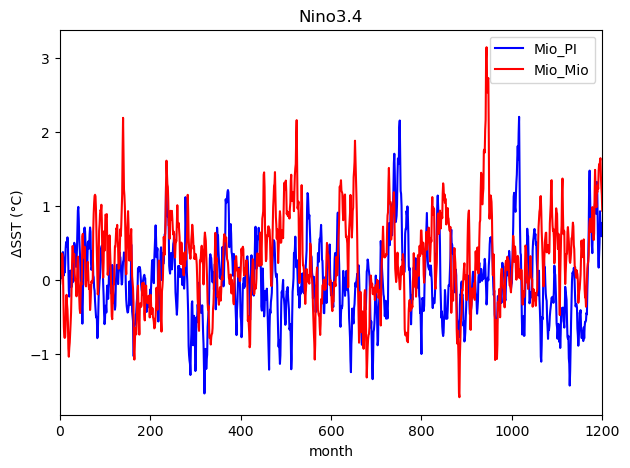

In [18]:
print(np.std(Nino3_Pi).values)
print(np.std(Nino3_Mio).values)

# Create the plot
fig, ax1 = plt.subplots()
fig.set_size_inches(7,5)

ax1.set_xlabel('month')
ax1.set_ylabel('ΔSST (°C)')
ax1.plot(np.arange(1,1201,1), Nino3_Pi, color='b')
ax1.plot(np.arange(1,1201,1), Nino3_Mio, color='r')

plt.title('Nino3.4')
plt.xlim(0, 1200)
plt.legend(['Mio_PI', 'Mio_Mio'])

# Show the plot
plt.show()

### Mio_Pi (Miocene simulation with Pre-industrial aerosols)

El Nino:  52
Neutral:  1117
La Nina:  31
[array(52), array(31), array(1117)]


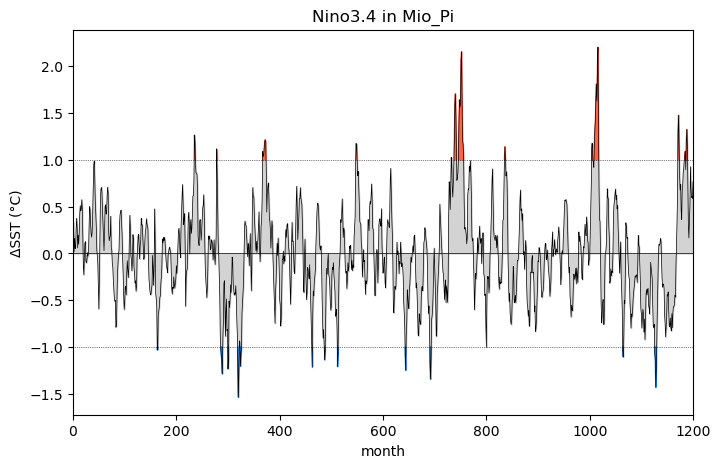

In [30]:
# --- Mio_PI: (Nino3 index) ---

elnino_Pi = Nino3_Pi.where(Nino3_Pi>=1)
lanina_Pi = Nino3_Pi.where(Nino3_Pi<=-1)
neutral_Pi = Nino3_Pi.where(np.logical_and(Nino3_Pi>-1, Nino3_Pi<1))

print('El Nino: ', elnino_Pi.count(dim='time').values)
print('Neutral: ', neutral_Pi.count(dim='time').values)
print('La Nina: ', lanina_Pi.count(dim='time').values)

counts_Pi=[elnino_Pi.count(dim='time').values,
        lanina_Pi.count(dim='time').values,
        neutral_Pi.count(dim='time').values]
print(counts_Pi)


# Create the plot
fig, ax2 = plt.subplots()
fig.set_size_inches(8,5)

ax2.set_xlabel('month')
ax2.set_ylabel('ΔSST (°C)')
ax2.plot(np.arange(1,1201,1), Nino3_Pi, color='k', linewidth=0.5)
plt.fill_between(np.arange(1,1201,1), Nino3_Pi, color='lightgrey')
plt.fill_between(np.arange(1,1201,1), elnino_Pi, y2=1.0, color='tomato')
plt.fill_between(np.arange(1,1201,1), lanina_Pi, y2=-1.0, color='dodgerblue')

plt.title('Nino3.4 in Mio_Pi')
plt.xlim(0, 1200)

plt.axhline(0, color='black', linewidth=0.5)
plt.axhline(1, color='black', linewidth=0.5, linestyle='dotted')
plt.axhline(-1, color='black', linewidth=0.5, linestyle='dotted')

# Show the plot
plt.show()

In [42]:
# --- (var.): precipitation ---

precc_Pi = ds_Pi['PRECC']
precl_Pi = ds_Pi['PRECL']
prec_Pi = (precc_Pi + precl_Pi)*1000*86400

prec_Pi_clim = prec_Pi.groupby('time.month').mean()
prec_Pi_ano = prec_Pi.groupby('time.month')-prec_Pi_clim

elnino_prec_Pi = prec_Pi_ano.sel(time=elnino_Pi.dropna(dim='time')['time']).mean(dim='time')
lanina_prec_Pi = prec_Pi_ano.sel(time=lanina_Pi.dropna(dim='time')['time']).mean(dim='time')
neutral_prec_Pi = prec_Pi_ano.sel(time=neutral_Pi.dropna(dim='time')['time']).mean(dim='time')

comp_precip_Pi = [elnino_prec_Pi,lanina_prec_Pi,neutral_prec_Pi]

/home/pchen25/.conda/envs/clim_data/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]


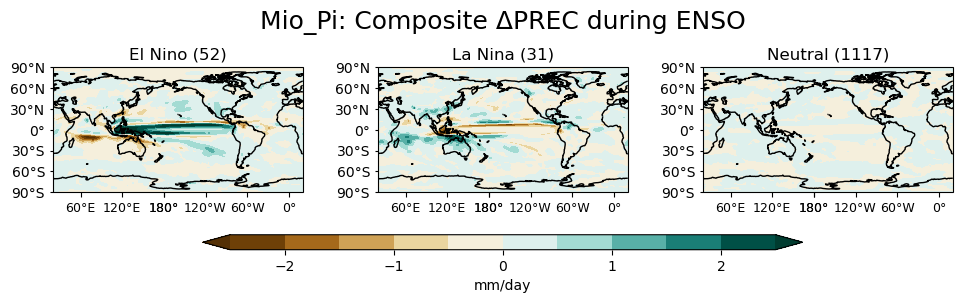

In [41]:
labels=['El Nino','La Nina', 'Neutral']
clevs = np.linspace(-2.5, 2.5, 11)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs_Pi = plt.subplots(nrows=1,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200)},
                        figsize=(10, 15))

#flatten axs into a 1-D array (just 3 rows)
axs_Pi = axs_Pi.flatten()

#Loop over all of the composites and plot
for i,enso in enumerate(comp_precip):

        # Select the season
        data = comp_precip_Pi[i]

        # Add the cyclic point
        data,lons = add_cyclic_point(data, coord=comp_precip_Pi[i]['lon'])

        # Contour plot
        cs=axs_Pi[i].contourf(lons,comp_precip_Pi[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

       # Longitude labels
        axs_Pi[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs_Pi[i].xaxis.set_major_formatter(lon_formatter)
        axs_Pi[i].tick_params(axis='y', size=2)             # set xtick parameters
        for xlabel in axs_Pi[i].get_xticklabels():          # set xticks_label
            xlabel.set_fontsize(9)     

        # Latitude labels
        axs_Pi[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs_Pi[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs_Pi[i].set_title(labels[i]+' ('+str(counts_Pi[i])+')')

        # Draw the coastines for each subplot
        axs_Pi[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.65, left=0.05, right=0.95, wspace=0.3, hspace=0.1)

# Add a colorbar
cax  = fig.add_axes([0.2, 0.37, 0.6, 0.01])    # set the [x0, y0, width, height] of the colorbar
CB   = plt.colorbar(cs, cax = cax, orientation='horizontal', label='mm/day')

# Add a big title at the top
plt.suptitle('Mio_Pi: Composite ΔPREC during ENSO', y=0.53, fontsize=18) ;

### Mio_Mio (Miocene simulation with Miocene aerosols)

El Nino:  133
Neutral:  1056
La Nina:  11
[array(133), array(11), array(1056)]


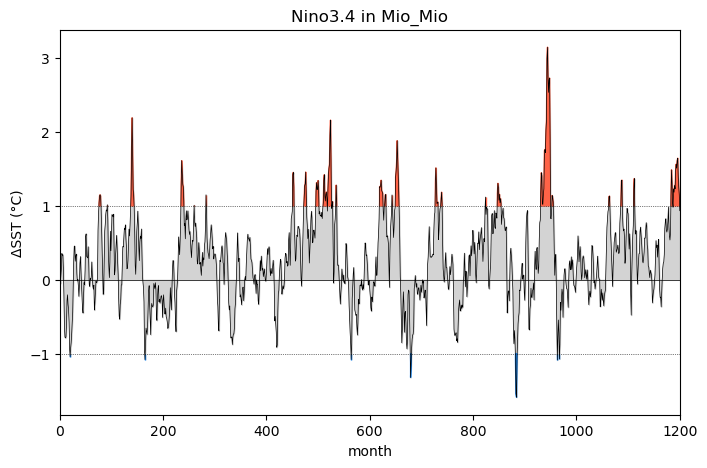

In [45]:
# --- Mio_Mio: (Nino3 index) ---

elnino_Mio = Nino3_Mio.where(Nino3_Mio>=1)
lanina_Mio = Nino3_Mio.where(Nino3_Mio<=-1)
neutral_Mio = Nino3_Mio.where(np.logical_and(Nino3_Mio>-1, Nino3_Mio<1))

print('El Nino: ', elnino_Mio.count(dim='time').values)
print('Neutral: ', neutral_Mio.count(dim='time').values)
print('La Nina: ', lanina_Mio.count(dim='time').values)

counts_Mio=[elnino_Mio.count(dim='time').values,
        lanina_Mio.count(dim='time').values,
        neutral_Mio.count(dim='time').values]
print(counts_Mio)

# Create the plot
fig, ax3 = plt.subplots()
fig.set_size_inches(8,5)

ax3.set_xlabel('month')
ax3.set_ylabel('ΔSST (°C)')
ax3.plot(np.arange(1,1201,1), Nino3_Mio, color='k', linewidth=0.5)
plt.fill_between(np.arange(1,1201,1), Nino3_Mio, color='lightgrey')
plt.fill_between(np.arange(1,1201,1), elnino_Mio, y2=1.0, color='tomato')
plt.fill_between(np.arange(1,1201,1), lanina_Mio, y2=-1.0, color='dodgerblue')

plt.title('Nino3.4 in Mio_Mio')
plt.xlim(0, 1200)

plt.axhline(0, color='black', linewidth=0.5)
plt.axhline(1, color='black', linewidth=0.5, linestyle='dotted')
plt.axhline(-1, color='black', linewidth=0.5, linestyle='dotted')

# Show the plot
plt.show()

In [43]:
# --- (var.): precipitation ---

precc_Mio = ds_Mio['PRECC'][1200:2400,:,:]
precl_Mio = ds_Mio['PRECL'][1200:2400,:,:]
prec_Mio = (precc_Mio + precl_Mio)*1000*86400

prec_Mio_clim = prec_Mio.groupby('time.month').mean()
prec_Mio_ano = prec_Mio.groupby('time.month')-prec_Mio_clim

elnino_prec_Mio = prec_Mio_ano.sel(time=elnino_Mio.dropna(dim='time')['time']).mean(dim='time')
lanina_prec_Mio = prec_Mio_ano.sel(time=lanina_Mio.dropna(dim='time')['time']).mean(dim='time')
neutral_prec_Mio = prec_Mio_ano.sel(time=neutral_Mio.dropna(dim='time')['time']).mean(dim='time')

comp_precip_Mio = [elnino_prec_Mio,lanina_prec_Mio,neutral_prec_Mio]

/home/pchen25/.conda/envs/clim_data/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]


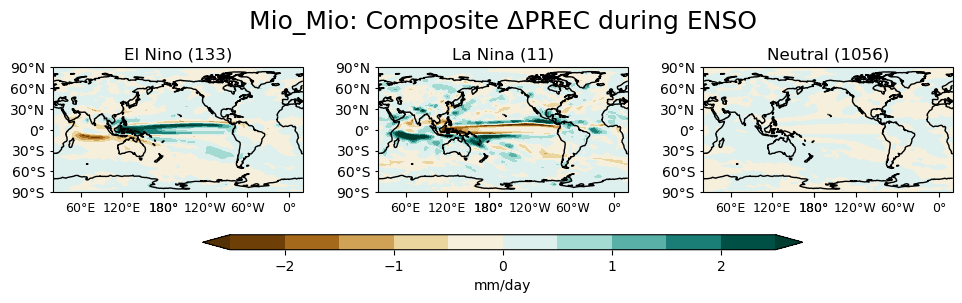

In [46]:
labels=['El Nino','La Nina', 'Neutral']
clevs = np.linspace(-2.5, 2.5, 11)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs_Mio = plt.subplots(nrows=1,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200)},
                        figsize=(10, 15))

#flatten axs into a 1-D array (just 3 rows)
axs_Mio = axs_Mio.flatten()

#Loop over all of the composites and plot
for i,enso in enumerate(comp_precip):

        # Select the season
        data = comp_precip_Mio[i]

        # Add the cyclic point
        data,lons = add_cyclic_point(data, coord=comp_precip_Mio[i]['lon'])

        # Contour plot
        cs=axs_Mio[i].contourf(lons,comp_precip_Mio[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

       # Longitude labels
        axs_Mio[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs_Mio[i].xaxis.set_major_formatter(lon_formatter)
        axs_Mio[i].tick_params(axis='y', size=2)             # set xtick parameters
        for xlabel in axs_Mio[i].get_xticklabels():          # set xticks_label
            xlabel.set_fontsize(9)     

        # Latitude labels
        axs_Mio[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs_Mio[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs_Mio[i].set_title(labels[i]+' ('+str(counts_Mio[i])+')')

        # Draw the coastines for each subplot
        axs_Mio[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.65, left=0.05, right=0.95, wspace=0.3, hspace=0.1)

# Add a colorbar
cax  = fig.add_axes([0.2, 0.37, 0.6, 0.01])    # set the [x0, y0, width, height] of the colorbar
CB   = plt.colorbar(cs, cax = cax, orientation='horizontal', label='mm/day')

# Add a big title at the top
plt.suptitle('Mio_Mio: Composite ΔPREC during ENSO', y=0.53, fontsize=18) ;